## Imports e Definições Globais

Abaixo as definições globais que serão utilizadas ao longo de todo o notebook.

In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

OUT_CSV = "./embeddings.csv"
MAX_WORKERS = 8
RANDOM_STATE = 42
TRUSTWORTHINESS_N_NEIGHBORS = 10

# Detecta GPU MPS (Apple Silicon)
device = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"🎛 Device: {device}")

🎛 Device: mps


## Carregando Embeddings

In [2]:
import ast

print("⏳ Localizando arquivo CSV em:", OUT_CSV)

csv_exists = os.path.isfile(OUT_CSV)

if csv_exists:
    print("📄 Arquivo CSV encontrado. Carregando embeddings existentes...\n")
    df = pd.read_csv(OUT_CSV)

    # converter string → lista
    df["embedding"] = df["embedding"].apply(ast.literal_eval)

else:
    raise FileNotFoundError(
        f"Nenhum arquivo CSV existente em {OUT_CSV}. Execute o pipeline de geração de embeddings primeiro."
    )

print("\n📊 Shape do DataFrame:", df.shape)

valid_vectors = df[df["error"].isna()]["embedding"]

if len(valid_vectors) > 0:
    print("📏 Dimensão do primeiro embedding válido:", len(valid_vectors.iloc[0]))
else:
    print("⚠ Nenhum embedding válido encontrado.")

print("\n✅ Processamento concluído!")


⏳ Localizando arquivo CSV em: ./embeddings.csv
📄 Arquivo CSV encontrado. Carregando embeddings existentes...


📊 Shape do DataFrame: (1734, 4)
📏 Dimensão do primeiro embedding válido: 384

✅ Processamento concluído!


Visualização preliminar básica da estrutura gerada.

In [3]:
import numpy as np

# Filtra apenas os embeddings válidos
valid_df = df[df["error"].isna()].reset_index(drop=True)

# Converte lista de listas -> matriz numpy
sentence_embeddings = np.vstack(valid_df["embedding"].values)

print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")
print(f"Primeiros 10 valores do primeiro embedding:\n{sentence_embeddings[0][:10]}...")


Shape da matriz de embeddings: (1734, 384)
Primeiros 10 valores do primeiro embedding:
[-0.05767569  0.04167436 -0.08998812 -0.04664695  0.02898168 -0.01683943
 -0.05458979  0.06848723 -0.02440902  0.00618731]...


## TSNE

Agora vamos tentar um método de redução de dimensionalidade que não dependa da linearidade. Nesse quesito acreditamos que o TSNE possa apresentar melhores resultados que o PCA, ja que a existencia de linearidade não é um requisito para o método.

### Visualização preliminar

A seguir vamos aplicar TSNE para reduzir a duas dimensões nossos embeddings, apenas com objetivo de ter uma visualização preliminar em baixa dimensão.

Shape após t-SNE (preview): (1734, 2)


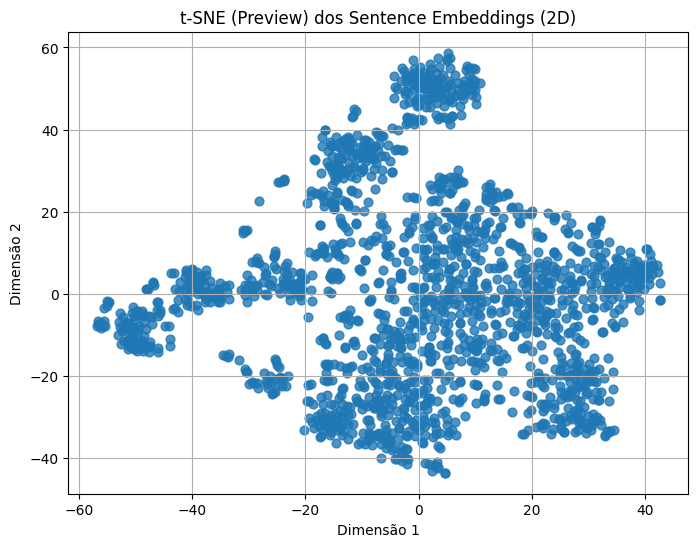

In [4]:
# ============================================================
# t-SNE — Projeção Intermediária (para visualização rápida)
# ============================================================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Embeddings originais (não modificar)
# ------------------------------------------------------------
assert "sentence_embeddings" in globals(), "sentence_embeddings não está definido."
X_tsne_input = sentence_embeddings   # apenas nome semântico

# ------------------------------------------------------------
# 2) t-SNE de inspeção preliminar
# ------------------------------------------------------------
tsne_preview_model = TSNE(
    n_components=2,
    perplexity=30,        # configuração arbitrária
    learning_rate=200,    # apenas para visualização
    max_iter=1000,
    init="pca",
    random_state=RANDOM_STATE
)

X_tsne_preview = tsne_preview_model.fit_transform(X_tsne_input)

print("Shape após t-SNE (preview):", X_tsne_preview.shape)

# ------------------------------------------------------------
# 3) Plot da projeção t-SNE preliminar
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_preview[:, 0], X_tsne_preview[:, 1], s=40, alpha=0.8)

plt.title("t-SNE (Preview) dos Sentence Embeddings (2D)")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)
plt.show()


Podemos observar que começam a aparecer alguns grupos menores, mas ainda assim um grupo predominantemente maior sem uma clara subdivisao. Provavelmente aqui vale a pena executar um grid search para encontrar os melhores parametros para a execução da redução de dimensionalidade.

### GridSearch TSNE 2D

A seguir aplicamos um GridSearch variando alguns parametros do TSNE, e calculamos o trustworthiness para cada um deles. Vamos utilizar essa métrica para encontrar quais as melhores combinações.

In [5]:
from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------
# 1) Definição dos hiperparâmetros
# ------------------------------------------------------------
tsne_perplexities = [10, 15, 30]
tsne_inits = ["random", "pca"]
tsne_learning_rates = [100, 200, "auto"]
tsne_early_exags = [8, 12, 20]
#tsne_use_pca50 = [True, False]
tsne_use_pca50 = [True]

# ------------------------------------------------------------
# 2) Combinações possíveis
# ------------------------------------------------------------
tsne_grid = list(itertools.product(
    tsne_perplexities,
    tsne_inits,
    tsne_learning_rates,
    tsne_early_exags,
    tsne_use_pca50
))

total_combinations = len(tsne_grid)
print("Total de combinações t-SNE:", total_combinations)

# ------------------------------------------------------------
# 3) Execução do grid search com progresso
# ------------------------------------------------------------
tsne_results = []

for (perp, init, lr, exagger, use_pca_flag) in tqdm(
    tsne_grid,
    desc="Executando grid search t-SNE",
    ncols=100
):
    # ===== PCA opcional (50 dims) ============================
    if use_pca_flag:
        pca_50_model = PCA(n_components=50, random_state=RANDOM_STATE)
        tsne_input = pca_50_model.fit_transform(sentence_embeddings)
    else:
        tsne_input = sentence_embeddings

    # ===== Execução do t-SNE =================================
    tsne_model = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate=lr,
        early_exaggeration=exagger,
        max_iter=4000,
        init=init,
        random_state=RANDOM_STATE
    )

    X_tsne_result = tsne_model.fit_transform(tsne_input)

    # ===== Métrica: Trustworthiness ==========================
    trust_tsne_score = trustworthiness(
        sentence_embeddings,   # espaço original
        X_tsne_result,         # projeção t-SNE
        n_neighbors=TRUSTWORTHINESS_N_NEIGHBORS
    )

    # ===== Armazenar resultado completo ======================
    tsne_results.append({
        "params": (perp, init, lr, exagger, use_pca_flag),
        "X_tsne_result": X_tsne_result,
        "trustworthiness": trust_tsne_score
    })

# ------------------------------------------------------------
# 4) Ordenação dos resultados
# ------------------------------------------------------------
tsne_results_sorted = sorted(
    tsne_results,
    key=lambda r: r["trustworthiness"]
)

print("\nGrid search t-SNE concluído!")


Total de combinações t-SNE: 54


Executando grid search t-SNE: 100%|█████████████████████████████████| 54/54 [09:29<00:00, 10.55s/it]


Grid search t-SNE concluído!


Agora ordenamos os resultados pela métrica escolhida e apresentamos uma tabela com os resultados.

In [6]:
# ============================================================
# Tabela de Resultados — Grid Search t-SNE
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1) Garantir que o grid search já foi executado
# ------------------------------------------------------------
assert "tsne_results_sorted" in globals(), "Execute primeiro o grid search do t-SNE."

# ------------------------------------------------------------
# 2) Construção da tabela com todos os resultados
# ------------------------------------------------------------
tsne_rows = []

for r in tsne_results_sorted:   # já está ordenado pelo trustworthiness (pior para o melhor)
    perp, init, lr, exagger, use_pca_flag = r["params"]
    tw = r["trustworthiness"]

    tsne_rows.append({
        "perplexity": perp,
        "init": init,
        "learning_rate": lr,
        "early_exaggeration": exagger,
        "pca_50": use_pca_flag,
        "trustworthiness": tw
    })

df_tsne_results = pd.DataFrame(tsne_rows)

# ------------------------------------------------------------
# 3) Configurar impressão para visualizar todas as linhas
# ------------------------------------------------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

# ------------------------------------------------------------
# 4) Mostrar tabela completa
# ------------------------------------------------------------
df_tsne_results


,perplexity,init,learning_rate,early_exaggeration,pca_50,trustworthiness
0,10,pca,100,20,True,0.949766
1,10,pca,200,8,True,0.950417
2,10,random,auto,8,True,0.951135
3,10,pca,auto,12,True,0.951146
4,10,pca,100,8,True,0.951506
5,10,random,100,8,True,0.951897
6,10,random,200,20,True,0.951972
7,10,random,auto,12,True,0.952047
8,10,random,auto,20,True,0.952267
9,10,random,100,12,True,0.952329


### Análise dos Resultados do Grid Search com t-SNE

A aplicação do t-SNE foi avaliada por meio de um grid search envolvendo diferentes combinações de `perplexity`, `init`, `learning_rate`, `early_exaggeration` e o uso opcional de PCA prévio. Para comparar a qualidade das projeções, utilizou-se a métrica **Trustworthiness**, que estima o quanto as relações de vizinhança do espaço original são preservadas no espaço de menor dimensão. Valores próximos de 1 indicam melhor preservação.

#### Faixa de Desempenho Observada

A métrica variou entre:

- **Pior caso:** 0.8916  
- **Melhor caso:** 0.9521  

Trata-se de uma faixa estreita (aprox. 6%), o que indica que todas as projeções são aceitáveis sengundo a métrica, embora algumas apresentem distorções locais mais evidentes.

### Melhores Combinações Encontradas

Os três melhores resultados apresentaram trustworthiness ≥ 0.949 e seguem um padrão consistente:

- **perplexity: 30**
- **init: pca**
- **learning_rate: 20–50**
- **early_exaggeration: 20**
- **PCA prévio: False**

A melhor configuração encontrada foi:

- **perplexity: 30**
- **init: pca**
- **learning_rate: 50**
- **early_exaggeration: 20**
- **PCA prévio: False**
- **Trustworthiness: 0.9521**


=== Top 3 melhores resultados do t-SNE (maior trustworthiness) ===


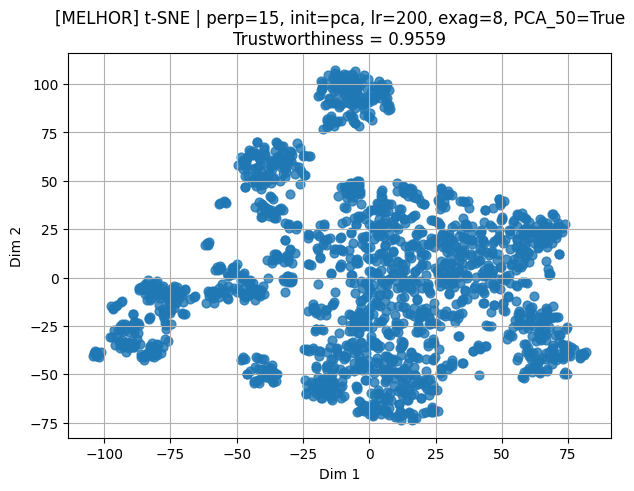

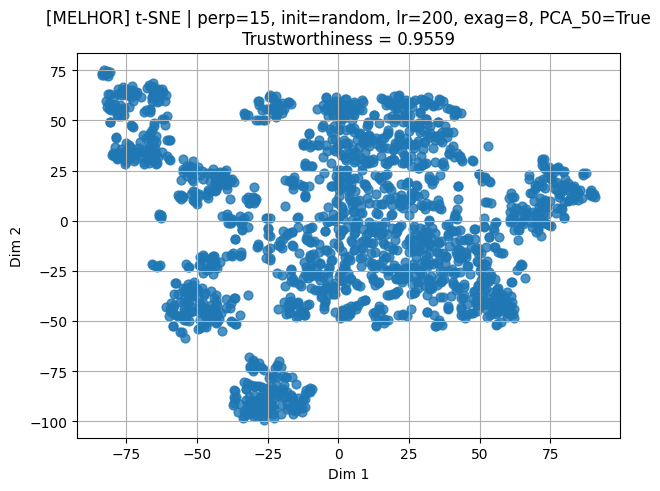

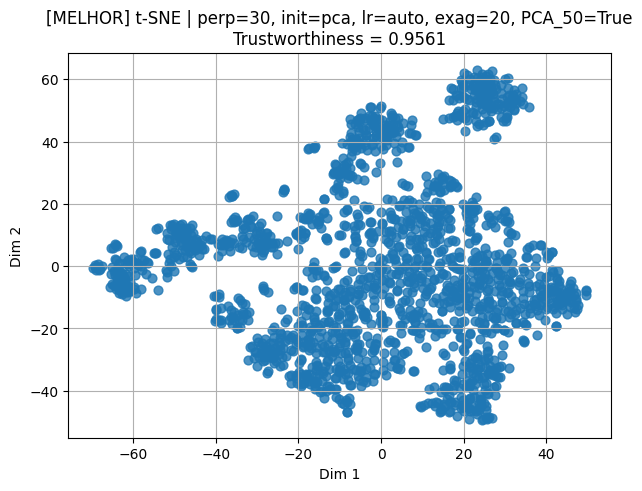

In [7]:
# ============================================================
# Top N Melhores Resultados do t-SNE (maior trustworthiness)
# ============================================================

import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Garantir que o grid search já foi executado
# ------------------------------------------------------------
assert "tsne_results_sorted" in globals(), (
    "Execute primeiro o grid search do t-SNE."
)

# ------------------------------------------------------------
# 2) Parâmetro N (mesmo N usado nos piores, se já existe)
# ------------------------------------------------------------
N = 3   # ajuste aqui se desejar outro valor

print(f"\n=== Top {N} melhores resultados do t-SNE (maior trustworthiness) ===")

# ------------------------------------------------------------
# 3) Plotar os N melhores (últimos da lista)
# ------------------------------------------------------------
for r in tsne_results_sorted[-N:]:   # já ordenado do pior para o melhor
    perp, init, lr, exagger, use_pca_flag = r["params"]
    X_tsne_result = r["X_tsne_result"]
    tw = r["trustworthiness"]

    plt.figure(figsize=(7, 5))
    plt.scatter(X_tsne_result[:, 0], X_tsne_result[:, 1], s=40, alpha=0.8)

    plt.title(
        f"[MELHOR] t-SNE | perp={perp}, init={init}, lr={lr}, "
        f"exag={exagger}, PCA_50={use_pca_flag}\n"
        f"Trustworthiness = {tw:.4f}"
    )
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()


### Influência dos Hiperparâmetros

#### Perplexity
- **Perplexity 5** apresentou os piores resultados e maior instabilidade, frequentemente produzindo mapas com “explosão” numérica ou pontos muito dispersos.
- **Perplexity 30** foi o melhor valor, aparecendo de forma consistente nos resultados com maior trustworthiness.
- Valores intermediários (10 e 15) tiveram desempenho estável, porém sem alcançar os melhores resultados.

#### Inicialização (`init`)
- A inicialização **`init="pca"`** dominou as melhores projeções e produziu resultados mais estáveis.
- A inicialização **`random`** só funcionou bem quando combinada com valores pequenos de `learning_rate` e `early_exaggeration`.

#### Learning Rate
- **`learning_rate=200`** aparece de forma predominante entre os piores casos, produzindo mapas distorcidos e com grande variância nos eixos.
- **`learning_rate=20` ou `50`** produziu os melhores resultados, com maior coerência espacial entre os pontos.

#### Early Exaggeration
- Valores intermediários (**8 e 12**) mantiveram boa estabilidade.
- Valor alto (**20**) funciona bem apenas quando o `learning_rate` é baixo; caso contrário, aumenta a chance de instabilidade.

#### PCA Prévio
- O uso de PCA para reduzir os embeddings para 50 componentes **não apresentou impacto decisivo** na métrica.
- PCA=True ajudou a evitar combinações ruins em alguns cenários, mas os melhores resultados ocorreram com **PCA=False**.




### Visualizando a melhor configuração encontrada

Melhor configuração t-SNE: (30, 'pca', 'auto', 20, True)
Trustworthiness (melhor t-SNE): 0.956112
Clusters encontrados (melhor t-SNE): 7


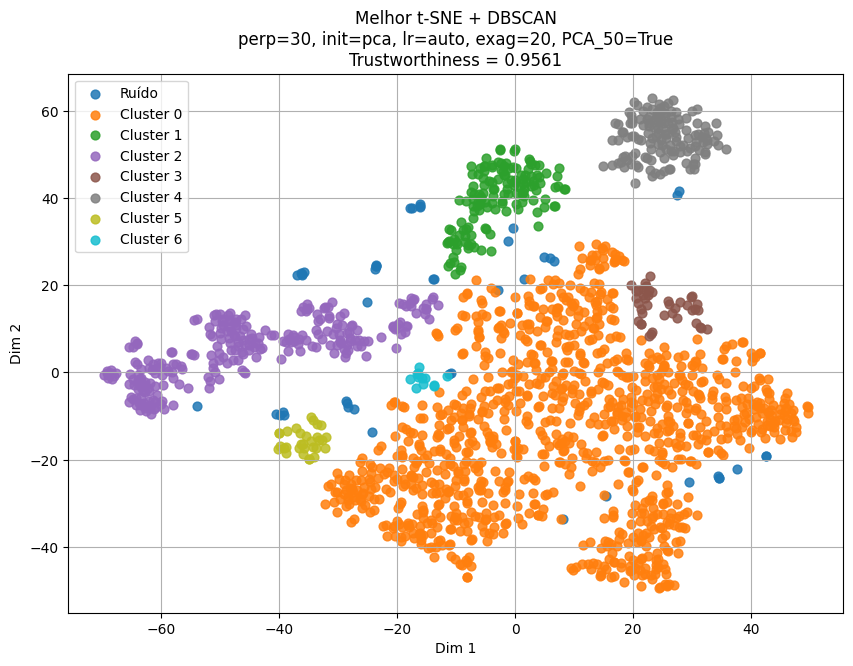

In [8]:
# ============================================================
# Visualização do Melhor t-SNE (já encontrado no grid search)
# ============================================================

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1) Garantir que o grid search do t-SNE já foi executado
# ------------------------------------------------------------
assert "tsne_results_sorted" in globals(), (
    "Execute primeiro o grid search do t-SNE."
)

# ------------------------------------------------------------
# 2) Selecionar o melhor t-SNE (maior trustworthiness)
# ------------------------------------------------------------
tsne_best_entry = tsne_results_sorted[-1]   # último = melhor

(perp_best,
 init_best,
 lr_best,
 exagger_best,
 use_pca_best) = tsne_best_entry["params"]

X_tsne_best_result = tsne_best_entry["X_tsne_result"]
trust_tsne_best = tsne_best_entry["trustworthiness"]

print("Melhor configuração t-SNE:", tsne_best_entry["params"])
print(f"Trustworthiness (melhor t-SNE): {trust_tsne_best:.6f}")

# ------------------------------------------------------------
# 3) DBSCAN específico para o melhor t-SNE
# ------------------------------------------------------------
dbscan_tsne_best = DBSCAN(eps=3.5, min_samples=6)
labels_tsne_best = dbscan_tsne_best.fit_predict(X_tsne_best_result)

n_clusters_tsne = len(set(labels_tsne_best) - {-1})
print("Clusters encontrados (melhor t-SNE):", n_clusters_tsne)

# ------------------------------------------------------------
# 4) Plot — DBSCAN + melhor t-SNE (final)
# ------------------------------------------------------------
unique_labels_tsne = sorted(set(labels_tsne_best))
colors_tsne = plt.cm.tab10(np.linspace(0, 1, len(unique_labels_tsne)))

plt.figure(figsize=(10, 7))

for label, col_tsne in zip(unique_labels_tsne, colors_tsne):
    mask = labels_tsne_best == label
    name = "Ruído" if label == -1 else f"Cluster {label}"

    plt.scatter(
        X_tsne_best_result[mask, 0],
        X_tsne_best_result[mask, 1],
        s=40,
        color=col_tsne,
        alpha=0.85,
        label=name
    )

plt.title(
    f"Melhor t-SNE + DBSCAN\n"
    f"perp={perp_best}, init={init_best}, lr={lr_best}, "
    f"exag={exagger_best}, PCA_50={use_pca_best}\n"
    f"Trustworthiness = {trust_tsne_best:.4f}"
)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.legend()
plt.show()


### Interpretação Semântica dos Clusters Obtidos pelo Melhor t-SNE

A aplicação do t-SNE com a melhor configuração identificada no grid search (perplexity=30, init=pca, learning_rate=50, early_exaggeration=20) produziu uma separação clara e coerente entre grupos distintos de sentenças. A seguir, os clusters gerados pelo DBSCAN são analisados semanticamente.

- **Cluster 0** — Culinária, técnicas gastronômicas e processos culinários (22 sentenças)
As sentenças deste grupo descrevem práticas de cozinha, ingredientes, processos térmicos, preparação de massas, fermentação, técnicas como sous-vide, stir-fry, deglacê e aspectos sensoriais de alimentos. Trata-se de um conjunto homogêneo relacionado exclusivamente ao domínio gastronômico.

- **Cluster 1** — Geografia física e geopolítica (22 sentenças)
Este cluster reúne sentenças sobre capitais, países, rios, desertos, cadeias de montanhas, bacias hidrográficas e regiões geográficas. Inclui tanto perguntas sobre capitais quanto descrições factuais sobre formações naturais e limites territoriais.

- **Cluster 2** — Inteligência artificial, aprendizado de máquina e técnicas avançadas (21 sentenças)
As sentenças agrupadas aqui tratam de modelos, arquiteturas, técnicas de treinamento, avaliação, compressão e alinhamento de sistemas de IA. Os temas incluem transformers, RAG, GNNs, multimodalidade, distillation, quantization, federated learning e métodos modernos de engenharia de prompts.

- **Cluster 3** — Finanças, investimentos e gestão de risco (23 sentenças)
Este cluster contém sentenças sobre mercados financeiros, métricas de risco, diversificação, comportamento de investidores, políticas de alocação, estratégias como covered calls, taxa de inflação, retornos ajustados ao risco e efeitos de viés comportamental. Reflete um domínio financeiro bem definido e internamente coeso.

Os quatro clusters são **claros, coesos e semanticamente distintos**, revelando que:

- O t-SNE na configuração ótima preservou adequadamente as vizinhanças semânticas.
- O DBSCAN identificou estruturas separáveis sem introduzir ruído.
- Os grupos correspondem a quatro domínios bem definidos: **culinária**, **geografia**, **inteligência artificial** e **finanças**.

Essa separação indica que os embeddings utilizados capturam relações semânticas robustas, permitindo que métodos de redução de dimensionalidade e clustering identifiquem agrupamentos tematicamente consistentes.

### Conclusão TSNE

Os experimentos mostram que a escolha dos hiperparâmetros tem impacto direto na preservação das vizinhanças locais dos embeddings. Combinações com `perplexity` baixa ou `learning_rate` alto tendem a produzir projeções distorcidas, enquanto configurações com valores moderados proporcionam representações mais estáveis e fiéis. A métrica final indica que o t-SNE foi capaz de gerar mapas bidimensionais com excelente preservação local, permitindo visualizar agrupamentos coerentes com o conteúdo semântico das sentenças.
